In [1]:
IMAGES_PATH="/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images"
LABELS_PATH="/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels"

In [2]:
def polygon_to_bbox(coords):
    xs = coords[0::2]
    ys = coords[1::2]
    return [
        min(xs),
        min(ys),
        max(xs),
        max(ys)
    ]

In [3]:
import cv2
import numpy as np
import os


In [4]:
IMG_SIZE = 224

In [5]:
def load_data(img_dir, label_dir):
    images = []
    boxes = []

    for file in os.listdir(img_dir):
        if not file.endswith(".jpg"):
            continue

        img_path = os.path.join(img_dir, file)
        label_path = os.path.join(label_dir, file.replace(".jpg", ".txt"))

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        
        if not os.path.exists(label_path):
            continue  

        with open(label_path) as f:
            vals = list(map(float, f.read().split()))
            if len(vals) <= 1:
                continue  

            bbox = polygon_to_bbox(vals[1:])
        
        images.append(img)
        boxes.append(bbox)

    return np.array(images), np.array(boxes)


In [6]:
from sklearn.model_selection import train_test_split

X, y = load_data(IMAGES_PATH, LABELS_PATH)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
import matplotlib.pyplot as plt

In [8]:
img = X_train[1]
h, w, _ = img.shape
xmin, ymin, xmax, ymax = y_train[1]

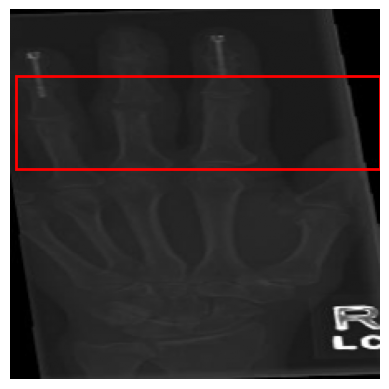

In [9]:
plt.imshow(img)
plt.gca().add_patch(
    plt.Rectangle(
        (xmin*w, ymin*h),
        (xmax-xmin)*w,
        (ymax-ymin)*h,
        edgecolor="red",
        fill=False,
        linewidth=2
    )
)
plt.axis("off")
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

2025-12-19 22:51:58.928146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766184719.132232      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766184719.187267      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [11]:


model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dense(4, activation="sigmoid")
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766184746.280456      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766184746.281095      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [13]:
lr_scheduler=ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.Huber(delta=1.0)
)

In [17]:
 from tensorflow.keras.utils import plot_model

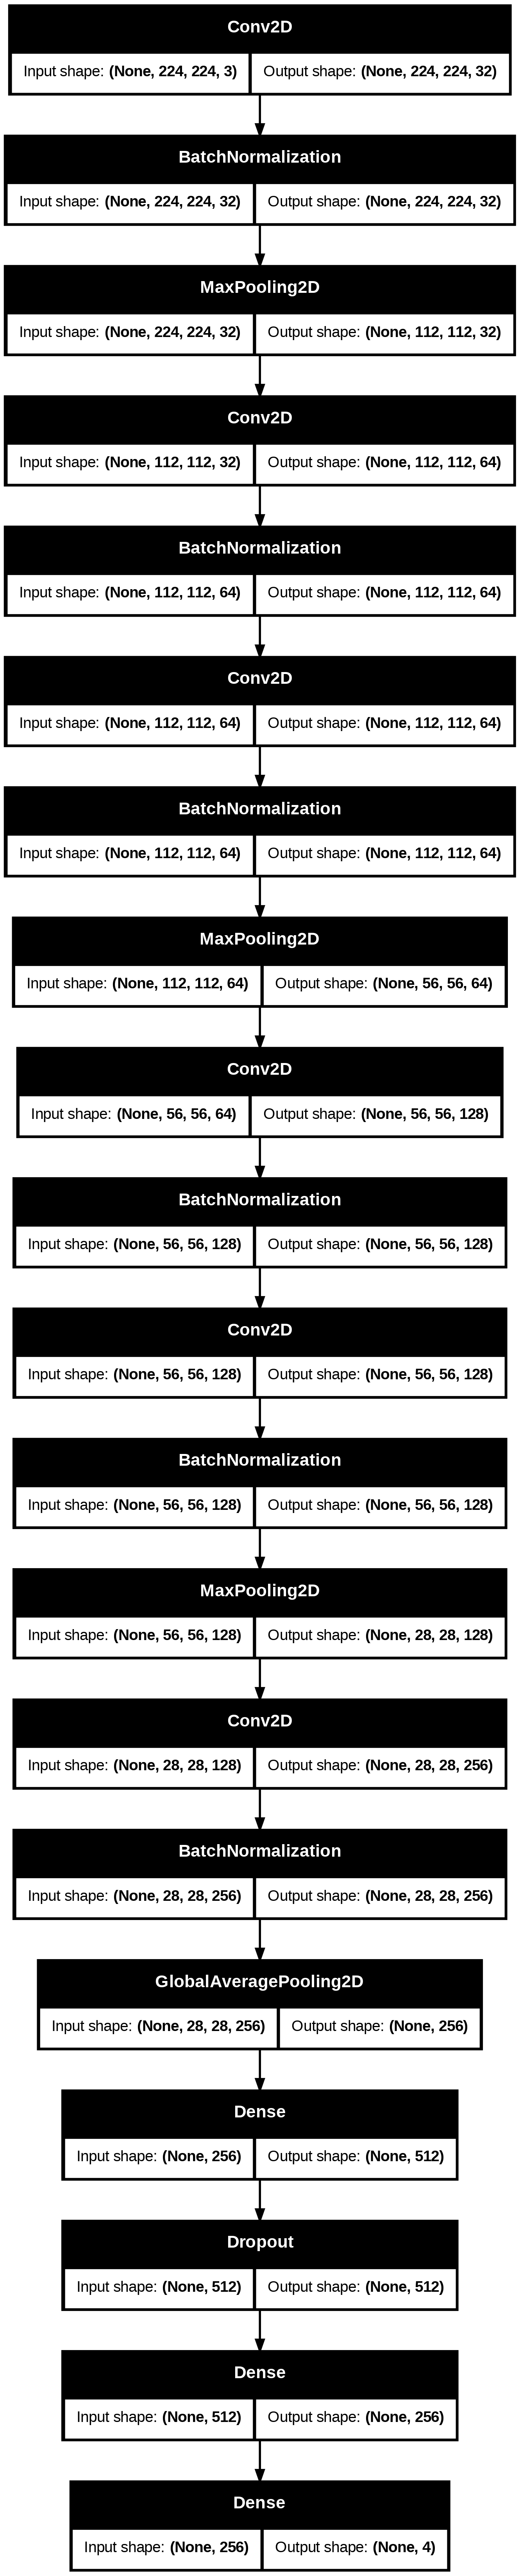

In [18]:
plot_model(model=model,show_shapes=True)

In [19]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=45,
    batch_size=8,
    callbacks=[lr_scheduler,early_stop]
)

Epoch 1/45


I0000 00:00:1766184842.880075     112 service.cc:148] XLA service 0x79d004049830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766184842.880868     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766184842.880889     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766184843.571015     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/181 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.1155  

I0000 00:00:1766184850.579424     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - loss: 0.0868 - val_loss: 0.0840 - learning_rate: 1.0000e-05
Epoch 2/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0898 - val_loss: 0.0822 - learning_rate: 1.0000e-05
Epoch 3/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0905 - val_loss: 0.0824 - learning_rate: 1.0000e-05
Epoch 4/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0809 - val_loss: 0.0823 - learning_rate: 1.0000e-05
Epoch 5/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0945 - val_loss: 0.0820 - learning_rate: 1.0000e-05
Epoch 6/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0947 - val_loss: 0.0823 - learning_rate: 1.0000e-05
Epoch 7/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0910 - val_loss: 0.0820 - learning_rate: 1.0000e-05
Epoch 8/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0791 - val_loss: 0.0821 - learning_rate: 1.0000e-05
Epoch 9/45
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0877 - val_loss: 0.0817 - l

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

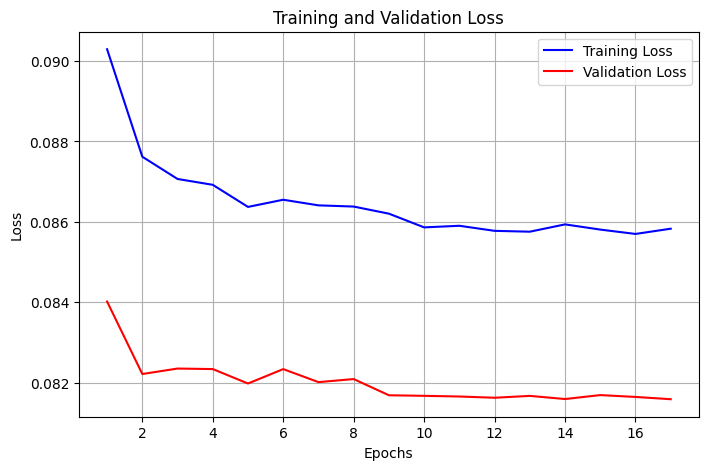

In [21]:
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def visualize_prediction(model, img, true_box=None):
    pred = model.predict(img[None])[0]
    h, w, _ = img.shape
    xmin, ymin, xmax, ymax = pred

    plt.imshow(img)
    plt.gca().add_patch(
        plt.Rectangle(
            (xmin*w, ymin*h),
            (xmax-xmin)*w,
            (ymax-ymin)*h,
            edgecolor="lime",
            fill=False,
            linewidth=2
        )
    )

    if true_box is not None:
        t_xmin, t_ymin, t_xmax, t_ymax = true_box
        plt.gca().add_patch(
            plt.Rectangle(
                (t_xmin*w, t_ymin*h),
                (t_xmax-t_xmin)*w,
                (t_ymax-t_ymin)*h,
                edgecolor="red",
                fill=False,
                linewidth=2
            )
        )
    plt.axis("off")
    plt.show()

In [40]:
def visualize_many_grid(model, X_val, y_val, n=20, cols=5):
    rows = n // cols
    indices = random.sample(range(len(X_val)), n)

    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)

        
        img = X_val[idx]
        gt_box = y_val[idx]
        pred_box = model.predict(img[None, ...], verbose=0)[0]

        
        h, w = img.shape[:2]

        def draw_box(box, color):
            x1, y1, x2, y2 = box
            x1, x2 = x1 * w, x2 * w
            y1, y2 = y1 * h, y2 * h
            plt.gca().add_patch(
                plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    edgecolor=color,
                    linewidth=2,
                )
            )

        plt.imshow(img)
        draw_box(gt_box, "green")   
        draw_box(pred_box, "red")   

        plt.axis("off")

    plt.tight_layout()
    plt.show()

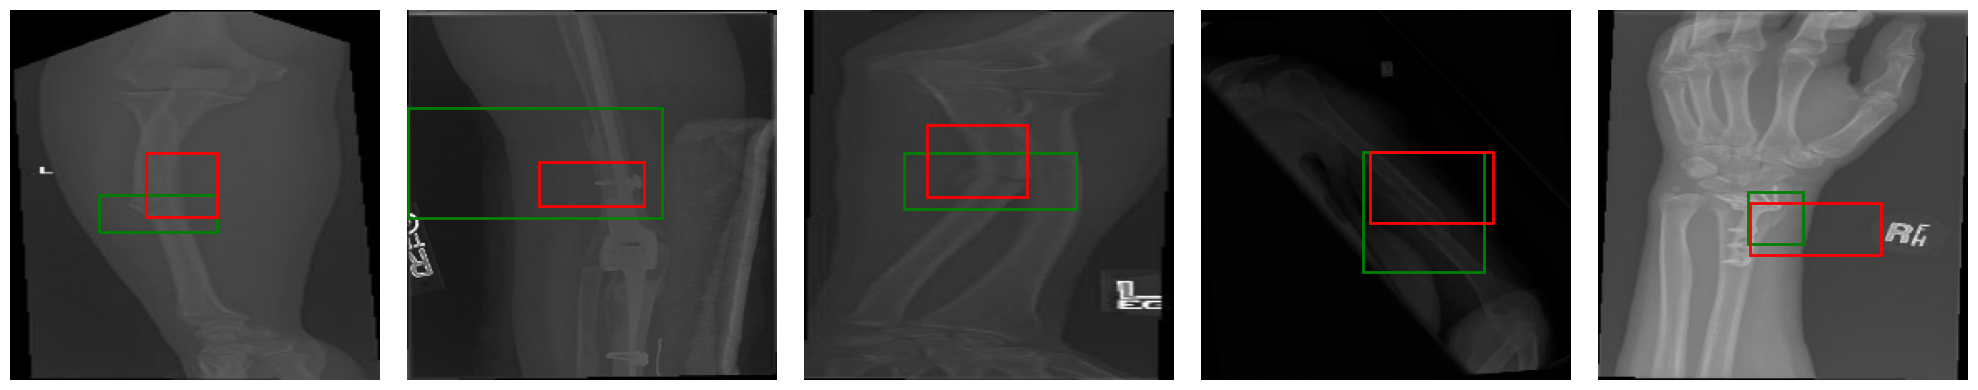

In [60]:
visualize_many_grid(model, X_val, y_val, n=5)


## Not the best accuracy to be honest , but very god result after tuning

In [90]:
MODEL_PATH = "/kaggle/working/fracture_bbox_model"

model.save(MODEL_PATH)

In [62]:
model.save("/kaggle/working/fracture_bbox_model.keras")

